In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import tqdm
import pandas as pd
import seaborn as sns
import json
import joblib
import warnings
from copy import deepcopy
from scipy import stats
from scipy import signal
from moseq2_extract.util import load_timestamps
from moseq2_pca.util import recursively_load_dict_contents_from_group, get_rps, get_changepoints
from moseq2_batch.util import recursive_find_h5s
from moseq2_viz.model.util import parse_model_results, get_syllable_slices, get_syllable_statistics, relabel_by_usage
from moseq2_viz.util import parse_index
from hyphyber.util.util import strided_app

In [3]:
def dff(raw, baseline, truncate=True):
    tmp = (raw - baseline) * 1e2 / baseline
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        if truncate:
            tmp[tmp<0] = 0
    return tmp

def nanzscore(sign, axis=1):
    
    mu = np.nanmean(sign, axis=axis)
    sig = np.nanstd(sign, axis=axis)
    
    if axis == 1:
        mu = mu[:, None]
        sig = sig[:, None]
        
    
    return (sign - mu) / sig

def compute_changepoints(frames):
    scores = get_rps(frames.reshape(-1, frames.shape[1] * frames.shape[2]))
    cps, score = get_changepoints(scores)
    
    return cps, score


def crosscorr(datax, datay, max_lag):
    
    lags = np.arange(-max_lag, max_lag+1, 1)
    r = np.zeros((len(lags),), dtype='float32')
    
    for i, lag in enumerate(lags):
        r[i] = datax.corr(datay.shift(lag))
    
    return r, lags


def extract_data(path, timestamps):
    
    # TODO: load in timestamps, insert nans into everything so we're on a uniform time grid
    
    f_phot = h5py.File(os.path.join(path, 'photometry.h5'), 'r')
    f_beh = h5py.File(os.path.join(path, 'results_00.h5'), 'r')
    
    phot_dat = recursively_load_dict_contents_from_group(f_phot, '/')
    beh_dat = recursively_load_dict_contents_from_group(f_beh, '/')
    cps , cp_score = compute_changepoints(beh_dat['frames'])
    
    gcamp_dff = dff(phot_dat['pmt00_ref00']['raw'], phot_dat['pmt00_ref00']['baseline'])
    rcamp_dff = dff(phot_dat['pmt01_ref01']['raw'], phot_dat['pmt01_ref01']['baseline'])
    scalars_arr = np.hstack(([v[:,None] for k, v in beh_dat['scalars'].items()]))
    
    print(gcamp_dff.shape)
    print(scalars_arr.shape)
    
    big_arr = np.hstack((scalars_arr, cp_score[:, None], gcamp_dff[:, None], rcamp_dff[:, None]))
    
    labels = [k for k in beh_dat['scalars'].keys()]
    labels.append('cps')
    labels.append('gcamp_dff')
    labels.append('rcamp_dff')
    
    df = pd.DataFrame(big_arr, columns=labels, index=timestamps)
    start_time = beh_dat['metadata']['extraction']['StartTime']
    subject_name = beh_dat['metadata']['extraction']['SubjectName'].lower()
    
    return df, start_time, subject_name


def trim_nans(labels, uuids, pca_path):
    
    trimmed_labels = deepcopy(labels)
    all_idx = {}
    
    with h5py.File(pca_path, 'r') as f:
        for i, uuid in enumerate(uuids):
            idx = f['scores_idx/{}'.format(uuid)].value
            trimmed_labels[i] = trimmed_labels[i][~np.isnan(idx)]
            all_idx[uuid] = idx
            


    return trimmed_labels, all_idx


def window_views(array, win_size, step_size, pad=True):
    
    use_array = deepcopy(array)
    
    if pad:
        use_array = np.pad(use_array, (win_size // 2, win_size // 2 - 1), 'edge')
    
    return strided_app(use_array, win_size, step_size)


def randomize_reduce(mat, reduce_fun, nrands):
    
    rand_vec = []
    m, n = mat.shape
    max_shift = n
    
    for i in range(nrands):
        col_start = np.random.randint(0, max_shift, mat.shape[0])
        idx = np.mod(col_start[:, None] + np.arange(n), n)
        cp = mat[np.arange(m)[:,None], idx]
        
        rand_vec.append(reduce_fun(cp))
        
    return rand_vec
    
    
def lagged_derivative(signal, k):
    dv = deepcopy(signal)
    dv[k // 2: - k // 2] = signal[k:] - signal[:-k]
    return dv

# TODO: signal derivative, high-pass

In [4]:
proc_dir="/n/groups/datta/slater/kinect_data/photometry/unsorted/180713/"

## Data munging

In [5]:
# find all of the data
os.chdir(proc_dir)
h5s, dicts, yaml = recursive_find_h5s(proc_dir)

In [6]:
# get the model fits and correct the timebase (i.e. remove nans)
os.chdir(proc_dir)
model_fit = '180713_SNr_photometry.p'
index_file = 'moseq2-index.yaml'
model_data = parse_model_results(joblib.load(model_fit))
index, _, _, _, _ = parse_index(index_file)
label_uuids = model_data['train_list']
labels = relabel_by_usage(model_data['labels'])
trimmed_labels, score_idx = trim_nans(labels, label_uuids, index['pca_path'])

In [7]:
to_process = [(os.path.dirname(h5), dct['uuid']) for h5, dct in zip(h5s, dicts)]

In [8]:
to_process = [(os.path.dirname(h5), dct['uuid']) for h5, dct in zip(h5s, dicts)]
proc_data = []
fs = dicts[0]['parameters']['fps']
for proc in tqdm.tqdm(to_process):
    
    timestamps = score_idx[proc[1]][~np.isnan(score_idx[proc[1]])] 
    df, start_time, subject_name = extract_data(proc[0], timestamps) #failing here SS
    df['model_labels'] = trimmed_labels[label_uuids.index(proc[1])]
    
    # reindex onto a uniform time grid
    
    df = df.reindex(np.arange(len(score_idx[proc[1]])), fill_value = np.nan)
    df['time'] = np.arange(len(score_idx[proc[1]])) / fs
    
    new_dict = {
        'df':df,
        'start_time':start_time,
        'subject_name':subject_name,
        'uuid':proc[1],
    }
    
    proc_data.append(new_dict)

 25%|██▌       | 1/4 [00:04<00:14,  4.81s/it]

(19172,)
(19172, 10)


 50%|█████     | 2/4 [00:10<00:10,  5.06s/it]

(21111,)
(21111, 10)


 75%|███████▌  | 3/4 [00:15<00:05,  5.22s/it]

(22151,)
(22151, 10)


100%|██████████| 4/4 [00:21<00:00,  5.48s/it]

(24836,)
(24836, 10)


## Visualization

In [9]:
ndatasets = len(proc_data)

In [10]:
sns.axes_style()

{'axes.facecolor': 'w',
 'axes.edgecolor': 'k',
 'axes.grid': False,
 'axes.axisbelow': 'line',
 'axes.linewidth': 0.8,
 'axes.labelcolor': 'k',
 'figure.facecolor': (1, 1, 1, 0),
 'grid.color': '#b0b0b0',
 'grid.linestyle': '-',
 'text.color': 'k',
 'xtick.color': 'k',
 'ytick.color': 'k',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0,
 'legend.frameon': True,
 'legend.numpoints': 1,
 'legend.scatterpoints': 1,
 'lines.solid_capstyle': 'projecting',
 'image.cmap': 'viridis',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['DejaVu Sans',
  'Bitstream Vera Sans',
  'Computer Modern Sans Serif',
  'Lucida Grande',
  'Verdana',
  'Geneva',
  'Lucid',
  'Arial',
  'Helvetica',
  'Avant Garde',
  'sans-serif']}

### Let's start with just plotting the raw data

In [11]:
list(proc_data[0]['df'])

['angle',
 'area',
 'centroid_x',
 'centroid_y',
 'height_ave',
 'length',
 'velocity_mag',
 'velocity_mag_3d',
 'velocity_theta',
 'width',
 'cps',
 'gcamp_dff',
 'rcamp_dff',
 'model_labels',
 'time']

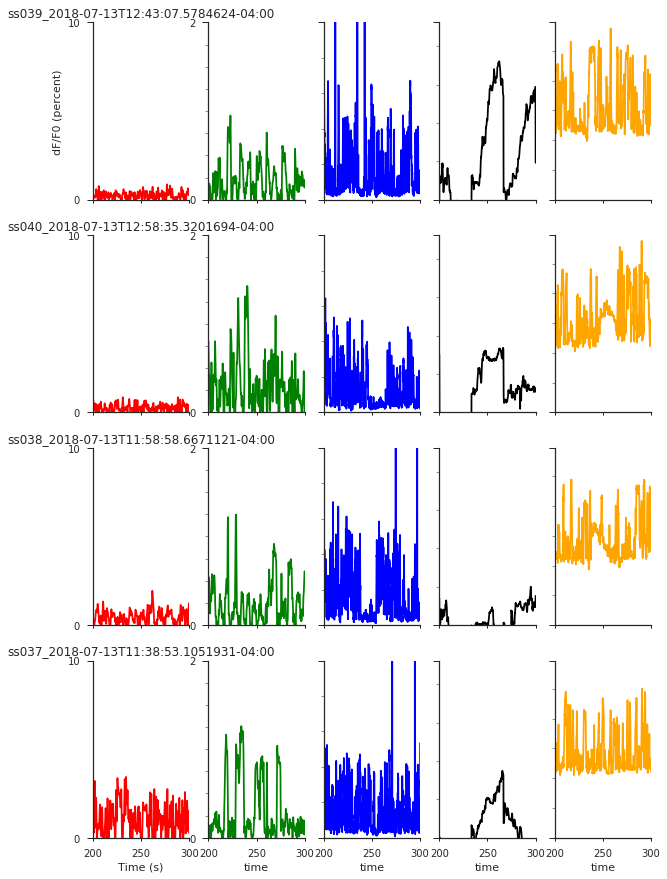

In [12]:
sns.set_style('ticks', {'xtick.major.size': 3.0})
sns.set_context('notebook')
fig,  ax  =  plt.subplots(ndatasets, 5, sharey='col', sharex=True)
fig.set_figwidth(10)
fig.set_figheight(15)
count = 0
smoothing = 5

for i, prc in enumerate(proc_data):
    prc['df'].rolling(smoothing).mean().plot(x='time', 
                                             y='rcamp_dff',
                                             ax=ax[i][0],
                                             color='r',
                                             legend=False)
    prc['df'].rolling(smoothing).mean().plot(x='time',
                                             y='gcamp_dff',
                                             ax=ax[i][1],
                                             color='g',
                                             legend=False)
    prc['df'].rolling(smoothing).mean().plot(x='time',
                                             y='velocity_mag',
                                             ax=ax[i][2],
                                             color='b',
                                             legend=False)
    prc['df'].rolling(smoothing).mean().plot(x='time',
                                             y='angle',
                                             ax=ax[i][3],
                                             color='black',
                                             legend=False)
    prc['df'].rolling(smoothing).mean().plot(x='time',
                                             y='height_ave',
                                             ax=ax[i][4],
                                             color='orange',
                                             legend=False)
    ax[i][0].set_title('{}_{}'.format(prc['subject_name'], prc['start_time']))
    
    
        
ax[0][0].set_ylim(0,10)
ax[0][1].set_ylim(0,2)
ax[0][2].set_ylim(0,10)
#ax[0][3].set_ylim(-100,100)

for i in range(len(proc_data)):
    for tk in ax[i][1].get_yticklabels():
        tk.set_visible(True)


ax[0][0].set_xlim(200,300)
ax[0][0].set_ylabel('dF/F0 (percent)')
ax[-1][0].set_xlabel('Time (s)')

ax = ax.ravel()

for i in range(len(ax)):
    maxval = np.around(np.max(np.abs(ax[i].get_ylim())), 2)
    
    ax[i].set_ylim(0, maxval)
    ax[i].set_yticks(ax[i].get_ylim())


sns.despine()
plt.show()

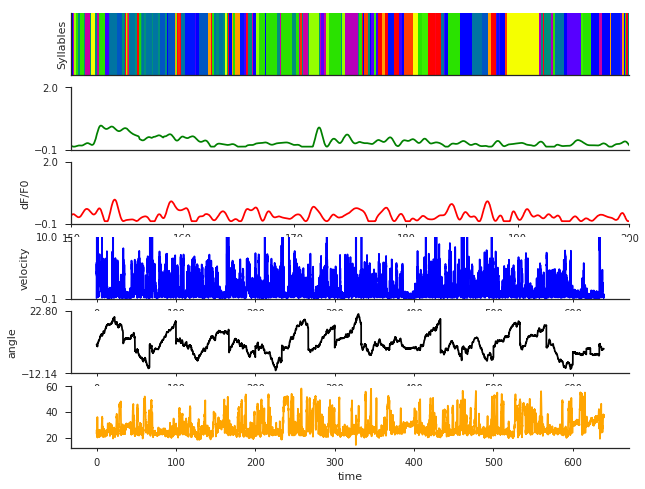

In [13]:
fig,  ax  =  plt.subplots(6, 1, sharey=False, sharex=False)
fig.set_figwidth(10)
fig.set_figheight(8)
proc_data[0]['df'].plot(x='time', 
                        y='height_ave',
                        ax=ax[5],
                        color='orange',
                        legend=False)
proc_data[0]['df'].plot(x='time', 
                        y='angle',
                        ax=ax[4],
                        color='black',
                        legend=False)
proc_data[0]['df'].plot(x='time', 
                        y='velocity_mag',
                        ax=ax[3],
                        color='b',
                        legend=False)
proc_data[0]['df'].plot(x='time', 
                        y='rcamp_dff',
                        ax=ax[2],
                        color='r',
                        legend=False)
proc_data[0]['df'].plot(x='time',
                        y='gcamp_dff',
                        ax=ax[1],
                        color='g',
                        legend=False) 
ax[0].imshow(np.tile(proc_data[0]['df']['model_labels'][None, :], (100,1)), aspect='auto', cmap='prism')
ax[0].set_yticks(())
ax[0].set_ylabel('Syllables')
ax[1].set_ylim(-0.1, 2)
ax[1].set_yticks(ax[1].get_ylim())
ax[1].axes.get_xaxis().set_visible(False)
ax[2].set_ylim(-0.1, 2)
ax[2].set_yticks(ax[2].get_ylim())
ax[2].set_ylabel('dF/F0')
ax[3].set_ylim(-0.1, 10)
ax[3].set_yticks(ax[3].get_ylim())
ax[3].set_ylabel('velocity')
ax[4].set_yticks(ax[4].get_ylim())
ax[4].set_ylabel('angle')

ax[0].set_xticks(())
ax[1].set_xticks(())

lims = (150,200)

ax[0].set_xlim(int(lims[0] * fs), int(lims[1] * fs))
ax[1].set_xlim(lims)
ax[2].set_xlim(lims)
ax[2].set_xlabel('Time (s)')

sns.despine()

### Next let's compute some simple lagged cross-correlations, focusing on sessions with appreciable signal

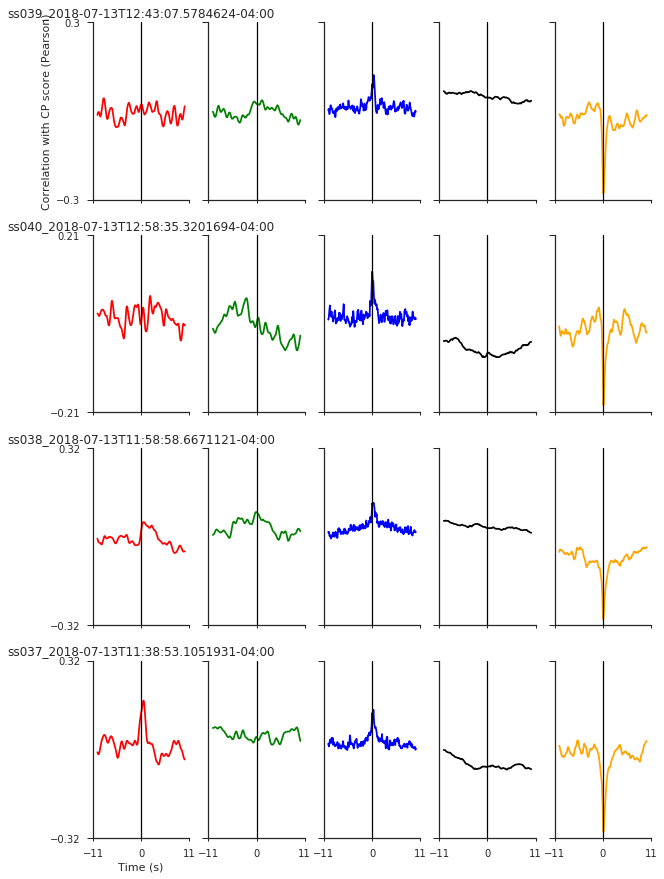

In [14]:
fig,  ax  =  plt.subplots(ndatasets, 5, sharey='row', sharex=True)
fig.set_figwidth(10)
fig.set_figheight(15)
count = 0

for i, prc in enumerate(proc_data):
    rcamp_r, lags = crosscorr(prc['df']['rcamp_dff'], prc['df']['cps'], 300)
    gcamp_r, _ = crosscorr(prc['df']['gcamp_dff'], prc['df']['cps'], 300)
    velocity_r, lags = crosscorr(prc['df']['velocity_mag'], prc['df']['cps'], 300)
    angle_r, lags = crosscorr(prc['df']['angle'], prc['df']['cps'], 300) 
    height_r, lags = crosscorr(prc['df']['height_ave'], prc['df']['cps'], 300) 
    ax[i][0].plot(lags / fs, rcamp_r, color='r')
    ax[i][1].plot(lags / fs, gcamp_r, color='g')
    ax[i][2].plot(lags / fs, velocity_r, color='b')
    ax[i][3].plot(lags / fs, angle_r, color='k')
    ax[i][4].plot(lags / fs, height_r, color='orange')
    ax[i][0].set_title('{}_{}'.format(prc['subject_name'], prc['start_time']))
    
    maxval = np.around(np.max(np.abs(ax[i][0].get_ylim())), 2)
    
    ax[i][0].set_ylim(-maxval, maxval)
    ax[i][0].set_yticks(ax[i][0].get_ylim())
    xlims = ax[i][0].get_xlim()
    ax[i][0].set_xticks([xlims[0], 0, xlims[1]])


for i in range(len(proc_data)):
    for tk in ax[i][1].get_yticklabels():
        tk.set_visible(True)

ax[0][0].set_ylabel('Correlation with CP score (Pearson)')
ax[-1][0].set_xlabel('Time (s)')

ax = ax.ravel()
sns.despine()

for i in range(len(ax)):
    ax[i].plot([0,0], ax[i].get_ylim(), color='k', linewidth=1.25)

plt.show()

### Model based analysis

In [15]:
sesh = 3

print(proc_data[sesh]['subject_name'])

ss037


In [16]:
changes = np.where(proc_data[sesh]['df']['model_labels'].diff().abs() > 0)[0]
changes_idx = proc_data[sesh]['df']['model_labels'][changes]

In [17]:
lag = 200 
gcamp_wins = window_views(proc_data[sesh]['df']['gcamp_dff'], int(lag * 2) + 1, 1)
rcamp_wins = window_views(proc_data[sesh]['df']['rcamp_dff'], int(lag * 2) + 1, 1)
velocity_wins = window_views(proc_data[sesh]['df']['velocity_mag'], int(lag * 2) + 1, 1)
angle_wins = window_views(proc_data[sesh]['df']['angle'], int(lag * 2) + 1, 1)
height_wins = window_views(proc_data[sesh]['df']['height_ave'], int(lag * 2) + 1, 1)

In [18]:
changes = changes[0:-1]
changes_idx = changes_idx[0:-1]

In [19]:
xvec = np.arange(-lag, lag + 1) / 30

/home/ss788/miniconda2/envs/moseq2/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: Mean of empty slice
/home/ss788/miniconda2/envs/moseq2/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/ss788/miniconda2/envs/moseq2/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


(-10, 10)

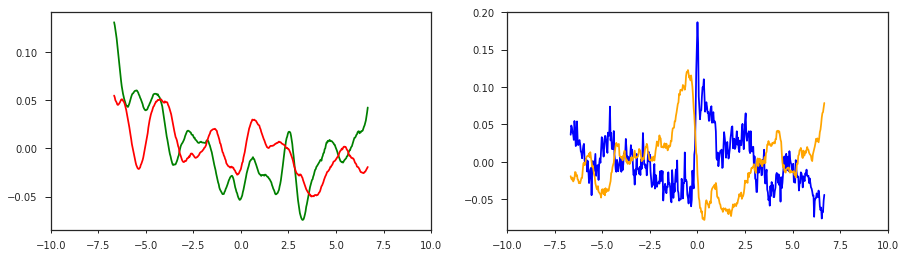

In [20]:
fig,  ax  =  plt.subplots(1, 2, sharey=False, sharex=True)

fig.set_figwidth(15)
fig.set_figheight(4)

ax[0].plot(xvec, np.nanmean(nanzscore(gcamp_wins[changes]), axis=0), color='g')
ax[0].plot(xvec, np.nanmean(nanzscore(rcamp_wins[changes]), axis=0), color='r')
ax[1].plot(xvec, np.nanmean(nanzscore(velocity_wins[changes]), axis=0), color='b')
ax[1].plot(xvec, np.nanmean(nanzscore(height_wins[changes]), axis=0), color='orange')
#ax[1].plot(xvec, np.nanmean(nanzscore(angle_wins[changes]), axis=0), color='k')
plt.xlim(-10, 10)

In [21]:
# get the averages

gcamp_ota = []
rcamp_ota = []
velocity_ota = []
angle_ota = []
height_ota = []
red_fun = lambda x: np.nanmean(x, axis=0)
nrands = 50

for i in tqdm.tqdm(range(30)):
    gcamp_tmp = gcamp_wins[changes[changes_idx==i]]
    rcamp_tmp = rcamp_wins[changes[changes_idx==i]]
    velocity_tmp = velocity_wins[changes[changes_idx==i]]
    angle_tmp = angle_wins[changes[changes_idx==i]]
    height_tmp = height_wins[changes[changes_idx==i]]
    
    gcamp_rnds = np.array(randomize_reduce(gcamp_tmp, red_fun, 50))
    rcamp_rnds = np.array(randomize_reduce(rcamp_tmp, red_fun, 50))
    velocity_rnds = np.array(randomize_reduce(velocity_tmp, red_fun, 50))
    angle_rnds = np.array(randomize_reduce(angle_tmp, red_fun, 50))
    height_rnds = np.array(randomize_reduce(height_tmp, red_fun, 50))

    gcamp_ota.append((np.nanmean(gcamp_tmp, axis=0) - np.nanmean(gcamp_rnds, axis=0)) / (np.nanstd(gcamp_rnds, axis=0)))
    rcamp_ota.append((np.nanmean(rcamp_tmp, axis=0) - np.nanmean(rcamp_rnds, axis=0)) / (np.nanstd(rcamp_rnds, axis=0)))
    velocity_ota.append((np.nanmean(velocity_tmp, axis=0) - np.nanmean(velocity_rnds, axis=0)) / (np.nanstd(velocity_rnds, axis=0)))
    angle_ota.append((np.nanmean(angle_tmp, axis=0) - np.nanmean(angle_rnds, axis=0)) / (np.nanstd(angle_rnds, axis=0)))
    height_ota.append((np.nanmean(height_tmp, axis=0) - np.nanmean(height_rnds, axis=0)) / (np.nanstd(height_rnds, axis=0)))

 70%|███████   | 21/30 [00:04<00:01,  4.57it/s]/home/ss788/miniconda2/envs/moseq2/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: Mean of empty slice
/home/ss788/miniconda2/envs/moseq2/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: Mean of empty slice
/home/ss788/miniconda2/envs/moseq2/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/ss788/miniconda2/envs/moseq2/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: Mean of empty slice
/home/ss788/miniconda2/envs/moseq2/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: Mean of empty slice
/home/ss788/miniconda2/envs/moseq2/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: Mean of empty slice
/home/ss788/miniconda2/envs/moseq2/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: Mean of empty slice
100%|██████████| 30/30 [00:04<00:00, 

In [22]:
use_idx = np.arange(lag - 5, lag + 10)
gcamp_aves = [x[use_idx[np.argmax(np.abs(x[use_idx]))]] for x in gcamp_ota]
rcamp_aves = [x[use_idx[np.argmax(np.abs(x[use_idx]))]] for x in rcamp_ota]
velocity_aves = [x[use_idx[np.argmax(np.abs(x[use_idx]))]] for x in velocity_ota]
height_aves = [x[use_idx[np.argmax(np.abs(x[use_idx]))]] for x in height_ota]

In [23]:
ave_df = pd.DataFrame(np.vstack((nanzscore(gcamp_aves, axis=0),
                                 nanzscore(rcamp_aves, axis=0),
                                 nanzscore(velocity_aves, axis=0),
                                 nanzscore(height_aves, axis=0))).T, 
                      columns=['GCaMP (dSPN axons)','RCaMP (SNr)', 'Velocity', 'Height'])

Text(0.5,1,'Peak z-scored dF/F0')

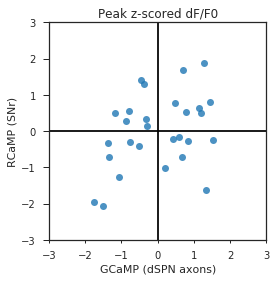

In [24]:
ax = sns.regplot(x='GCaMP (dSPN axons)', y='RCaMP (SNr)', data=ave_df, fit_reg=False)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal')
ax.plot([-3, 3],[0, 0], color='k')
ax.plot([0, 0],[-3,3], color='k')
ax.set_title('Peak z-scored dF/F0')

Text(0.5,1,'Peak z-scored dF/F0')

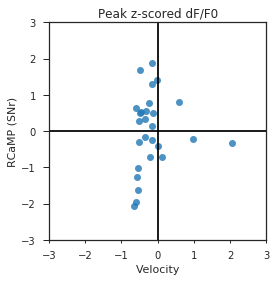

In [25]:
ax = sns.regplot(x='Velocity', y='RCaMP (SNr)', data=ave_df, fit_reg=False)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal')
ax.plot([-3, 3],[0, 0], color='k')
ax.plot([0, 0],[-3,3], color='k')
ax.set_title('Peak z-scored dF/F0')

Text(0.5,1,'Peak z-scored dF/F0')

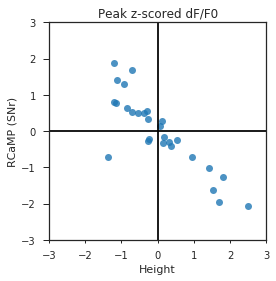

In [26]:
ax = sns.regplot(x='Height', y='RCaMP (SNr)', data=ave_df, fit_reg=False)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect('equal')
ax.plot([-3, 3],[0, 0], color='k')
ax.plot([0, 0],[-3,3], color='k')
ax.set_title('Peak z-scored dF/F0')

## Onset-triggered average, z-scored using random time-shuffles

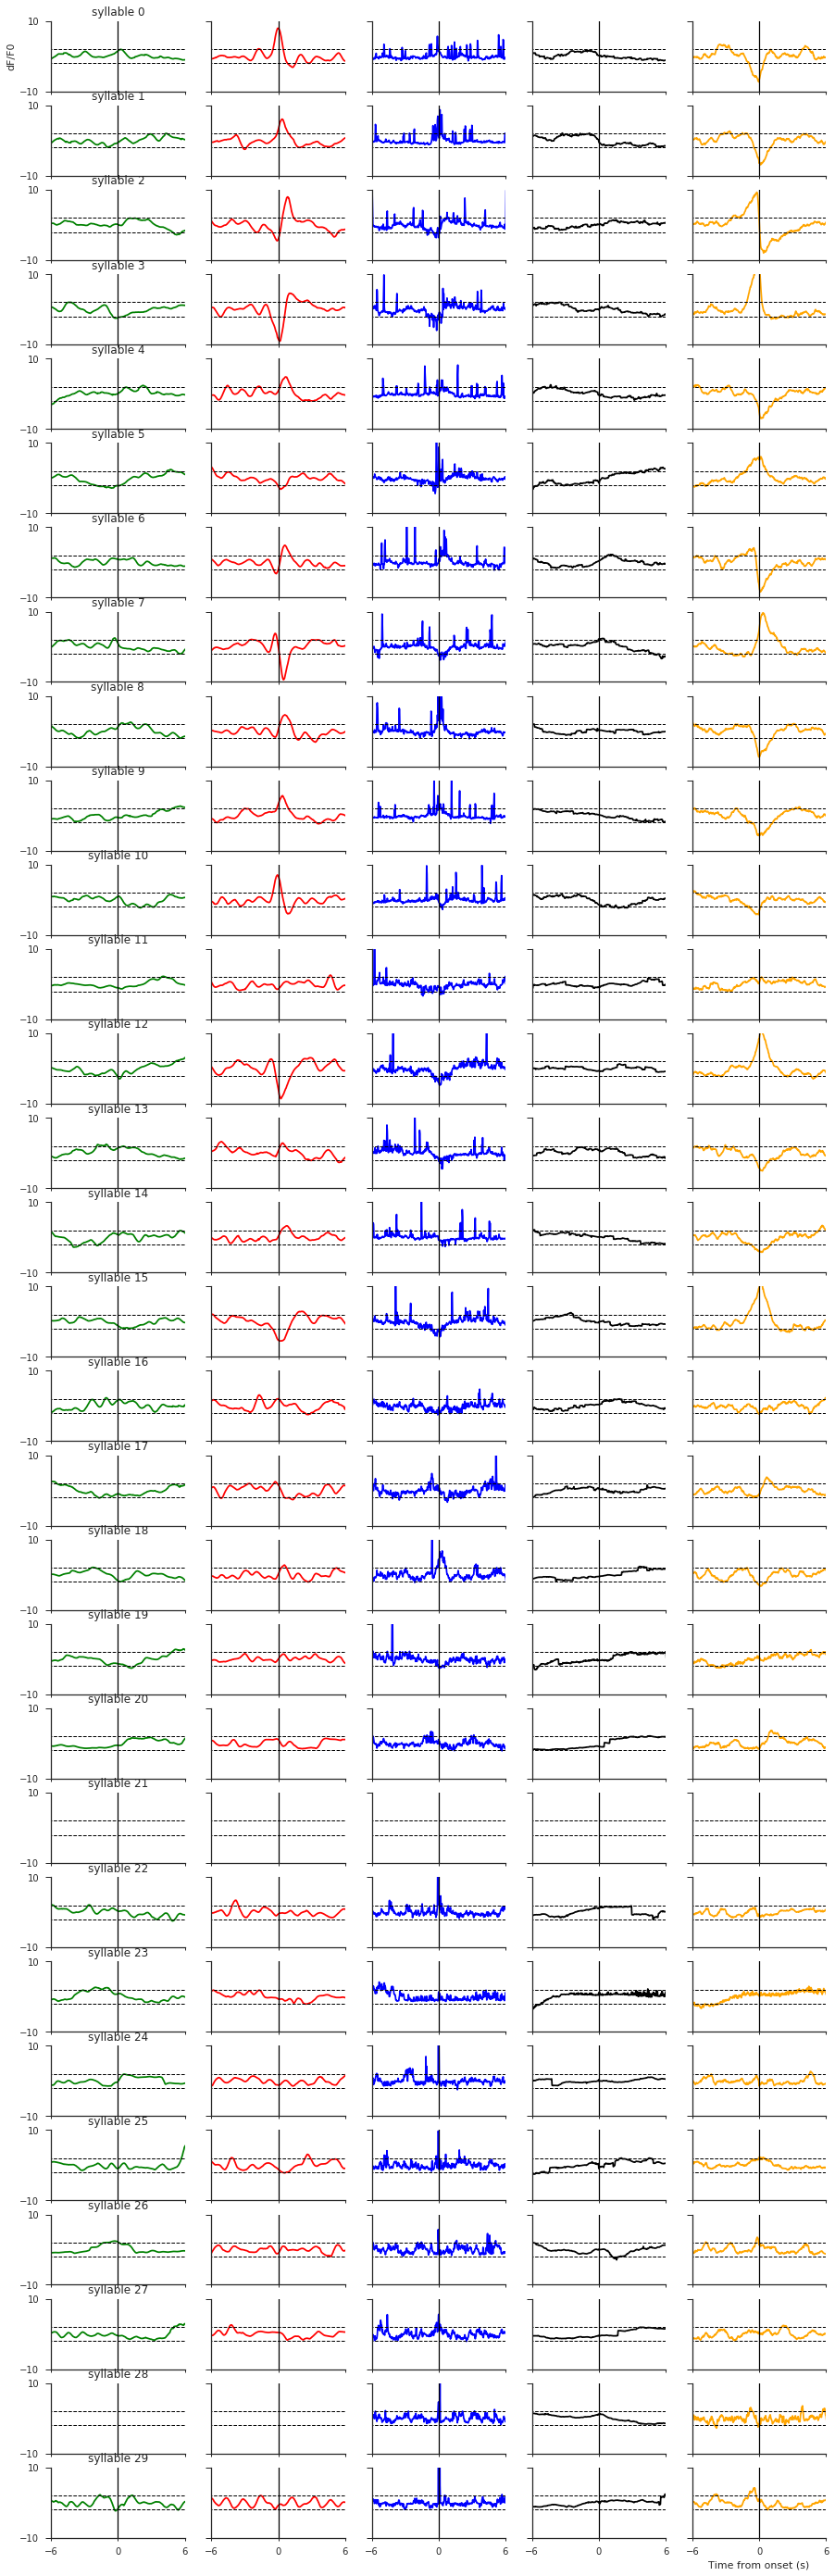

In [27]:
fig,  ax  =  plt.subplots(len(gcamp_aves), 5, sharey=True, sharex=True)
fig.set_figwidth(15)
fig.set_figheight(50)
count = 0

ax = ax.ravel()

n = 0
for i, tup in enumerate(zip(gcamp_ota, rcamp_ota, velocity_ota, angle_ota, height_ota)):
    ax[n].plot(xvec, tup[0], color='g')
    ax[n+1].plot(xvec, tup[1], color='r')
    ax[n+2].plot(xvec, tup[2], color='b')
    ax[n+3].plot(xvec, tup[3], color='k')
    ax[n+4].plot(xvec, tup[4], color='orange')
    
    ax[n].set_title('syllable {:d}'.format(i))
    n = n + 5;

for i in range(n):
    ax[i].plot([0,0],[-20,20], color='k', linewidth=1.25)    
    ax[i].plot([xvec[0], xvec[-1]], [2, 2], color='k', linestyle='--', linewidth=1)
    ax[i].plot([xvec[0], xvec[-1]], [-2, -2], color='k', linestyle='--', linewidth=1)
    
ax[0].set_ylabel('dF/F0')
ax[0].set_xlim(-6, 6)
ax[0].set_ylim(-10, 10)

for i in range(len(ax)):
    ax[i].set_yticks(ax[i].get_ylim())
    xlims = ax[i].get_xlim()
    ax[i].set_xticks([xlims[0], 0, xlims[1]])

sns.despine()

ax[-1].set_xlabel('Time from onset (s)')

plt.show()

In [ ]:
# 